In [ ]:
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format
pd.set_option("display.max_rows", None)  # 모든 행 출력
pd.set_option("display.max_columns", None)  # 모든 열 출력
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import os
from itertools import product
from functions import (load_parameters, load_generation_data, load_price_data, generate_randomized_generation,
generate_rt_scenarios, plot_generation_data, plot_randomized_generation, plot_scenarios_for_generator, plot_rt_scenarios, plot_summary)

generation_data, I, T = load_generation_data(date_filter="2022-07-18")
S, R, P_RT, K, K0, M1, M2 = load_parameters(I, T, generation_data)
P_DA, P_PN = load_price_data()

✅ 총 4개 파일을 불러왔습니다: 1201.csv, 137.csv, 401.csv, 89.csv
📊 데이터 Shape: I=4, T=24, S=20
✅ 시뮬레이션 초기화 완료: S=20, Randomness='high', M1=757.14, M2=1596.38


/Users/jangseohyun/Documents/workspace/symply/DER/functions.py:96: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  nyc_rt["Hour"] = nyc_rt["Time Stamp"].dt.floor("H")


In [31]:
only = gp.Model("only")
only.setParam("MIPGap", 1e-7)

x = only.addVars(I, T, vtype=GRB.CONTINUOUS, lb=0, name="x")
yp = only.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_plus")
ym = only.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_minus")
z = only.addVars(I, T+1, S, vtype=GRB.CONTINUOUS, name="z")
zc = only.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="z_charge")
zd = only.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="z_discharge")
zeta = only.addVars(I, T, S, vtype=GRB.BINARY, name="zeta")
delta = only.addVars(I, T, S, vtype=GRB.BINARY, name="delta")
rho = only.addVars(I, T, S, vtype=GRB.BINARY, name="rho")

only.update()

obj = gp.quicksum(P_DA[t] * x[i, t] for i, t in product(range(I), range(T))) \
    + gp.quicksum(1 / S * (P_RT[t, s] * yp[i, t, s] - P_PN[t] * ym[i, t, s]) for i, t, s in product(range(I), range(T), range(S)))

only.setObjective(obj, GRB.MAXIMIZE)

for i, t, s in product(range(I), range(T), range(S)):
    only.addConstr(R[i, t, s] - x[i, t] == yp[i, t, s] - ym[i, t, s] + zc[i, t, s] - zd[i, t, s])
    only.addConstr(yp[i, t, s] <= R[i, t, s])
    only.addConstr(z[i, t + 1, s] == z[i, t, s] + zc[i, t, s] - zd[i, t, s])
    only.addConstr(zd[i, t, s] <= z[i, t, s])
    only.addConstr(zc[i, t, s] <= K[i] - z[i, t, s])
    only.addConstr(yp[i, t, s] <= M1 * rho[i, t, s])
    only.addConstr(ym[i, t, s] <= M1 * (1 - rho[i, t, s]))
    only.addConstr(ym[i, t, s] <= M1 * delta[i, t, s])
    only.addConstr(zc[i, t, s] <= M1 * (1 - delta[i, t, s]))
    only.addConstr(zc[i, t, s] <= M1 * zeta[i, t, s])
    only.addConstr(zd[i, t, s] <= M1 * (1 - zeta[i, t, s]))
for i, s in product(range(I), range(S)):
    only.addConstr(z[i, 0, s] == K0[i])

only.optimize()

if only.status == GRB.OPTIMAL:
    print(f"Optimal solution found! Objective value: {only.objVal}")
else:
    print("No optimal solution found.")

# x_vals = np.array([[x[i, t].X for t in range(T)] for i in range(I)])
# yp_vals = np.array([[[yp[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)]) 
# ym_vals = np.array([[[ym[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
# z_vals  = np.array([[[z[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
# zc_vals = np.array([[[zc[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
# zd_vals = np.array([[[zd[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])

# x_sum = np.sum(x_vals, axis=0)
# yp_sum = np.sum(yp_vals, axis=0)
# ym_sum = np.sum(ym_vals, axis=0)
# z_sum = np.sum(z_vals, axis=0)
# zc_sum = np.sum(zc_vals, axis=0)
# zd_sum = np.sum(zd_vals, axis=0)

Set parameter MIPGap to value 1e-07
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.3.0 24D81)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
MIPGap  1e-07

Optimize a model with 21200 rows, 15536 columns and 50000 nonzeros
Model fingerprint: 0xcd5cbdf8
Variable types: 9776 continuous, 5760 integer (5760 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+02]
  Objective range  [2e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 8e+02]
Presolve removed 16840 rows and 12032 columns
Presolve time: 0.62s
Presolved: 4360 rows, 3504 columns, 11026 nonzeros
Variable types: 2204 continuous, 1300 integer (1300 binary)
Found heuristic solution: objective 966499.42574
Found heuristic solution: objective 1013469.3376

Root relaxation: objective 1.143761e+06, 2040 iterations, 0.02 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds   

In [32]:
agg = gp.Model("agg")
agg.setParam("MIPGap", 1e-7)

a = agg.addVars(T, vtype=GRB.CONTINUOUS, name="alpha")
bp = agg.addVars(T, S, vtype=GRB.CONTINUOUS, name="beta_plus")
bm = agg.addVars(T, S, vtype=GRB.CONTINUOUS, name="beta_minus")
g = agg.addVars(T+1, S, vtype=GRB.CONTINUOUS, name="gamma")
gc = agg.addVars(T, S, vtype=GRB.CONTINUOUS, name="gamma_charge")
gd = agg.addVars(T, S, vtype=GRB.CONTINUOUS, name="gamma_discharge")
eta = agg.addVars(T, S, vtype=GRB.BINARY, name="eta")
lam = agg.addVars(T, S, vtype=GRB.BINARY, name="lambda")
mu = agg.addVars(T, S, vtype=GRB.BINARY, name="mu")

agg.update()

obj = gp.quicksum(P_DA[t] * a[t] for t in range(T)) + \
      gp.quicksum(1 / S * (P_RT[t, s] * bp[t, s] - P_PN[t] * bm[t, s])
                  for t, s in product(range(T), range(S)))

agg.setObjective(obj, GRB.MAXIMIZE)

for t, s in product(range(T), range(S)):
    agg.addConstr(gp.quicksum(R[i, t, s] for i in range(I)) - a[t] == bp[t, s] - bm[t, s] + gc[t, s] - gd[t, s])
    agg.addConstr(bp[t, s] <= gp.quicksum(R[i, t, s] for i in range(I)))
    agg.addConstr(g[t + 1, s] == g[t, s] + gc[t, s] - gd[t, s])
    agg.addConstr(gd[t, s] <= g[t, s])
    agg.addConstr(gc[t, s] <= sum(K) - g[t, s])
    agg.addConstr(bp[t, s] <= M2 * mu[t, s])
    agg.addConstr(bm[t, s] <= M2 * (1 - mu[t, s]))
    agg.addConstr(bm[t, s] <= M2 * eta[t, s])
    agg.addConstr(gc[t, s] <= M2 * (1 - eta[t, s]))
    agg.addConstr(gc[t, s] <= M2 * lam[t, s])
    agg.addConstr(gd[t, s] <= M2 * (1 - lam[t, s]))
for s in range(S):
    agg.addConstr(g[0, s] == sum(K0))

agg.optimize()

if agg.status == GRB.OPTIMAL:
    print(f"Optimal solution found! Objective value: {agg.objVal}")
else:
    print("No optimal solution found.")

agg_a_vals  = np.array([agg.getVarByName(f"alpha[{t}]").X for t in range(T)])
agg_bp_vals = np.array([[agg.getVarByName(f"beta_plus[{t},{s}]").X for s in range(S)] for t in range(T)])
agg_bm_vals = np.array([[agg.getVarByName(f"beta_minus[{t},{s}]").X for s in range(S)] for t in range(T)])
agg_gc_vals = np.array([[agg.getVarByName(f"gamma_charge[{t},{s}]").X for s in range(S)] for t in range(T)])
agg_gd_vals = np.array([[agg.getVarByName(f"gamma_discharge[{t},{s}]").X for s in range(S)] for t in range(T)])
agg_g_vals  = np.array([[agg.getVarByName(f"gamma[{t},{s}]").X for s in range(S)] for t in range(T + 1)])

Set parameter MIPGap to value 1e-07
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.3.0 24D81)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
MIPGap  1e-07

Optimize a model with 5300 rows, 3884 columns and 12500 nonzeros
Model fingerprint: 0x5fdf9a9d
Variable types: 2444 continuous, 1440 integer (1440 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [2e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 2e+03]
Presolve removed 940 rows and 380 columns
Presolve time: 0.01s
Presolved: 4360 rows, 3504 columns, 11000 nonzeros
Variable types: 2204 continuous, 1300 integer (1300 binary)
Found heuristic solution: objective 1111649.9351

Root relaxation: objective 1.159019e+06, 1886 iterations, 0.02 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incum

In [33]:
set= gp.Model("set")
set.setParam("MIPGap", 1e-7)

a = set.addVars(T, vtype=GRB.CONTINUOUS, name="alpha")
bp = set.addVars(T, S, vtype=GRB.CONTINUOUS, name="beta_plus")
bm = set.addVars(T, S, vtype=GRB.CONTINUOUS, name="beta_minus")
g = set.addVars(T+1, S, vtype=GRB.CONTINUOUS, name="gamma")
gc = set.addVars(T, S, vtype=GRB.CONTINUOUS, name="gamma_charge")
gd = set.addVars(T, S, vtype=GRB.CONTINUOUS, name="gamma_discharge")
eta = set.addVars(T, S, vtype=GRB.BINARY, name="eta")
lam = set.addVars(T, S, vtype=GRB.BINARY, name="lambda")
mu = set.addVars(T, S, vtype=GRB.BINARY, name="mu")

x = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="x")
yp = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_plus")
ym = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_minus")
z = set.addVars(I, T+1, S, vtype=GRB.CONTINUOUS, name="z")
zc = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="z_charge")
zd = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="z_discharge")
zeta = set.addVars(I, T, S, vtype=GRB.BINARY, name="zeta")
delta = set.addVars(I, T, S, vtype=GRB.BINARY, name="delta")
rho = set.addVars(I, T, S, vtype=GRB.BINARY, name="rho")

pool  = set.addVars(T, S, vtype=GRB.CONTINUOUS, name="pool")
supply = set.addVars(T, S, vtype=GRB.CONTINUOUS, name="poolp")
demand = set.addVars(T, S, vtype=GRB.CONTINUOUS, name="poolm")
dp  = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="poolp")
dm  = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="poolm")
d = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="d")
dyp_p = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="dyp+")
dyp_m = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="dyp-")
dym_p = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="dym_p")
dym_m = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="dym_m")
dzc_p = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="dzc_p")
dzc_m = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="dzc_m")
dzd_p = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="dzd_p")
dzd_m = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="dzd_m")
q1 = set.addVars(I, T, S, vtype=GRB.BINARY, name="q1")
q2 = set.addVars(I, T, S, vtype=GRB.BINARY, name="q2")
q3 = set.addVars(I, T, S, vtype=GRB.BINARY, name="q3")
q4 = set.addVars(I, T, S, vtype=GRB.BINARY, name="q4")
q5 = set.addVars(I, T, S, vtype=GRB.BINARY, name="q5")
q6 = set.addVars(I, T, S, vtype=GRB.BINARY, name="q3")
q7 = set.addVars(I, T, S, vtype=GRB.BINARY, name="q4")
q8 = set.addVars(I, T, S, vtype=GRB.BINARY, name="q5")

e = set.addVars(I, T+1, S, vtype=GRB.CONTINUOUS, name="e")
ep = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="e_plus")
em = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="e_minus")
ec = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="e_charge")
ed = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="e_discharge")

set.update()

obj = gp.quicksum(P_DA[t] * a[t] for t in range(T)) + \
      gp.quicksum((1 / S) * (P_RT[t, s] * bp[t, s] - P_PN[t] * bm[t, s]) for t in range(T) for s in range(S))
      
set.setObjective(obj, GRB.MAXIMIZE)                                                                                                                                                                                                                      

for t, s in product(range(T), range(S)):
    set.addConstr(gp.quicksum(R[i, t, s] for i in range(I)) - a[t] == bp[t, s] - bm[t, s] + gc[t, s] - gd[t, s])
    set.addConstr(bp[t, s] <= gp.quicksum(R[i, t, s] for i in range(I)))
    set.addConstr(g[t + 1, s] == g[t, s] + gc[t, s] - gd[t, s])
    set.addConstr(gd[t, s] <= g[t, s])
    set.addConstr(gc[t, s] <= sum(K) - g[t, s])
    set.addConstr(bp[t, s] <= M2 * mu[t, s])
    set.addConstr(bm[t, s] <= M2 * (1 - mu[t, s]))
    set.addConstr(bm[t, s] <= M2 * eta[t, s])
    set.addConstr(gc[t, s] <= M2 * (1 - eta[t, s]))
    set.addConstr(gc[t, s] <= M2 * lam[t, s])
    set.addConstr(gd[t, s] <= M2 * (1 - lam[t, s]))
for s in range(S):
    set.addConstr(g[0, s] == sum(K0))

for t, s in product(range(T), range(S)):
    set.addConstr(a[t] == gp.quicksum(x[i, t, s] for i in range(I)))
    set.addConstr(bp[t, s] == gp.quicksum(ep[i, t, s] for i in range(I)))
    set.addConstr(bm[t, s] == gp.quicksum(em[i, t, s] for i in range(I)))
    set.addConstr(g[t, s] == gp.quicksum(z[i, t, s] for i in range(I)))
    set.addConstr(gc[t, s] == gp.quicksum(ec[i, t, s] for i in range(I)))
    set.addConstr(gd[t, s] == gp.quicksum(ed[i, t, s] for i in range(I)))
    set.addConstr(g[t + 1, s] == g[t, s] + gc[t, s] - gd[t, s])
    
    # set.addConstr(gp.quicksum(x[i, t, s] for i in range(I)) == float(a_vals[t]))
    # set.addConstr(gp.quicksum(ep[i, t, s] for i in range(I)) == float(bp_vals[t, s]))
    # set.addConstr(gp.quicksum(em[i, t, s] for i in range(I)) == float(bm_vals[t, s]))
    # set.addConstr(gp.quicksum(z[i, t, s]  for i in range(I)) == float(g_vals[t, s]))
    # set.addConstr(gp.quicksum(ec[i, t, s] for i in range(I)) == float(gc_vals[t, s]))
    # set.addConstr(gp.quicksum(ed[i, t, s] for i in range(I)) == float(gd_vals[t, s]))

for i, t, s in product(range(I), range(T), range(S)):
    set.addConstr(R[i, t, s] - x[i, t, s] == yp[i, t, s] - ym[i, t, s] + zc[i, t, s] - zd[i, t, s])
    set.addConstr(yp[i, t, s] <= R[i, t, s])
    set.addConstr(zd[i, t, s] <= z[i, t, s])
    set.addConstr(zc[i, t, s] <= K[i] - z[i, t, s])
    set.addConstr(yp[i, t, s] <= M1 * rho[i, t, s])
    set.addConstr(ym[i, t, s] <= M1 * (1 - rho[i, t, s]))
    set.addConstr(ym[i, t, s] <= M1 * delta[i, t, s])
    set.addConstr(zc[i, t, s] <= M1 * (1 - delta[i, t, s]))
    set.addConstr(zc[i, t, s] <= M1 * zeta[i, t, s])
    set.addConstr(zd[i, t, s] <= M1 * (1 - zeta[i, t, s]))
    set.addConstr(z[i, t + 1, s] == z[i, t, s] + ec[i, t, s] - ed[i, t, s])
    set.addConstr(z[i, t, s] <= K[i])
for i, s in product(range(I), range(S)):
    set.addConstr(z[i, 0, s] == K0[i])

for i, t, s in product(range(I), range(T), range(S)):
    set.addConstr(yp[i, t, s] - ep[i, t, s] == dyp_p[i, t, s] - dyp_m[i, t, s])
    set.addConstr(yp[i, t, s] >= ep[i, t, s])
    set.addConstr(dyp_p[i, t, s] <= M1 * q1[i, t, s])
    set.addConstr(dyp_m[i, t, s] <= M1 * (1 - q1[i, t, s]))
    
    set.addConstr(ym[i, t, s] - em[i, t, s] == dym_p[i, t, s] - dym_m[i, t, s])
    set.addConstr(ym[i, t, s] >= em[i, t, s])
    set.addConstr(dym_p[i, t, s] <= M1 * q2[i, t, s])
    set.addConstr(dym_m[i, t, s] <= M1 * (1 - q2[i, t, s]))
    
    # set.addConstr(R[i, t, s] - x[i, t, s] == ep[i, t, s] - em[i, t, s] + dyp_p[i, t, s] - dyp_m[i, t, s] - dym_p[i, t, s] + dym_m[i, t, s] + zc[i, t, s] - zd[i, t, s])
    # set.addConstr(e[i, t, s] + ec[i, t, s] - ed[i, t, s] == dyp_p[i, t, s] - dyp_m[i, t, s] - dym_p[i, t, s] + dym_m[i, t, s] + z[i, t, s] + zc[i, t, s] - zd[i, t, s])
    # set.addConstr(z[i, t, s] >= e[i, t, s])
    
    set.addConstr(zc[i, t, s] - ec[i, t, s] == dzc_p[i, t, s] - dzc_m[i, t, s])
    # set.addConstr(zc[i, t, s] >= ec[i, t, s])
    set.addConstr(dzc_p[i, t, s] <= M1 * q3[i, t, s])
    set.addConstr(dzc_m[i, t, s] <= M1 * (1 - q3[i, t, s]))
    set.addConstr(ec[i, t, s] <= K[i] - z[i, t, s])
    
    set.addConstr(zd[i, t, s] - ed[i, t, s] == dzd_p[i, t, s] - dzd_m[i, t, s])
    set.addConstr(dzd_p[i, t, s] <= M1 * q4[i, t, s])
    set.addConstr(dzd_m[i, t, s] <= M1 * (1 - q4[i, t, s]))
    set.addConstr(ed[i, t, s] <= z[i, t, s])
    set.addConstr(zd[i, t, s] <= ed[i, t, s])
    
    set.addConstr(ep[i, t, s] <= M1 * q5[i, t, s])
    set.addConstr(em[i, t, s] <= M1 * (1 - q5[i, t, s]))
    set.addConstr(em[i, t, s] <= M1 * q6[i, t, s])
    set.addConstr(ec[i, t, s] <= M1 * (1 - q6[i, t, s]))
    set.addConstr(ec[i, t, s] <= M1 * q7[i, t, s])
    set.addConstr(ed[i, t, s] <= M1 * (1 - q7[i, t, s]))
    
    # set.addConstr(dp[i, t, s] == dyp_p[i, t, s] + dym_p[i, t, s] + dzc_p[i, t, s] + dzd_p[i, t, s])
    # set.addConstr(dm[i, t, s] == dyp_m[i, t, s] + dym_m[i, t, s] + dzc_m[i, t, s] + dzd_m[i, t, s])
    # set.addConstr(dp[i, t, s] <= M1 * q8[i, t, s])
    # set.addConstr(dm[i, t, s] <= M1 * (1 - q8[i, t, s]))
    # set.addConstr(supply[t, s] == gp.quicksum(dp[i, t, s] for i in range(I)) + gp.quicksum(z[i, t, s] - zd[i, t, s] for i in range(I)))
    # set.addConstr(demand[t, s] == gp.quicksum(dm[i, t, s] for i in range(I)))
    
set.optimize()

if set.status == GRB.OPTIMAL:
    print(f"Optimal solution found! Objective value: {set.objVal}")
else:
    print("No optimal solution found.")
    
a_vals  = np.array([set.getVarByName(f"alpha[{t}]").X for t in range(T)])
bp_vals = np.array([[set.getVarByName(f"beta_plus[{t},{s}]").X for s in range(S)] for t in range(T)])
bm_vals = np.array([[set.getVarByName(f"beta_minus[{t},{s}]").X for s in range(S)] for t in range(T)])
gc_vals = np.array([[set.getVarByName(f"gamma_charge[{t},{s}]").X for s in range(S)] for t in range(T)])
gd_vals = np.array([[set.getVarByName(f"gamma_discharge[{t},{s}]").X for s in range(S)] for t in range(T)])
g_vals  = np.array([[set.getVarByName(f"gamma[{t},{s}]").X for s in range(S)] for t in range(T + 1)])

x_vals   = np.array([[[set.getVarByName(f"x[{i},{t},{s}]").X for s in range(S)] for t in range(T)] for i in range(I)])
yp_vals  = np.array([[[set.getVarByName(f"y_plus[{i},{t},{s}]").X for s in range(S)] for t in range(T)] for i in range(I)])
ym_vals  = np.array([[[set.getVarByName(f"y_minus[{i},{t},{s}]").X for s in range(S)] for t in range(T)] for i in range(I)])
zc_vals  = np.array([[[set.getVarByName(f"z_charge[{i},{t},{s}]").X for s in range(S)] for t in range(T)] for i in range(I)])
zd_vals  = np.array([[[set.getVarByName(f"z_discharge[{i},{t},{s}]").X for s in range(S)] for t in range(T)] for i in range(I)])
z_vals   = np.array([[[set.getVarByName(f"z[{i},{t},{s}]").X for s in range(S)] for t in range(T+1)] for i in range(I)])

e_vals  = np.array([[[set.getVarByName(f"e[{i},{t},{s}]").X for s in range(S)] for t in range(T)] for i in range(I)])
ep_vals  = np.array([[[set.getVarByName(f"e_plus[{i},{t},{s}]").X for s in range(S)] for t in range(T)] for i in range(I)])
em_vals  = np.array([[[set.getVarByName(f"e_minus[{i},{t},{s}]").X for s in range(S)] for t in range(T)] for i in range(I)])
ec_vals  = np.array([[[set.getVarByName(f"e_charge[{i},{t},{s}]").X for s in range(S)] for t in range(T)] for i in range(I)])
ed_vals  = np.array([[[set.getVarByName(f"e_discharge[{i},{t},{s}]").X for s in range(S)] for t in range(T)] for i in range(I)])

Set parameter MIPGap to value 1e-07
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.3.0 24D81)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
MIPGap  1e-07

Optimize a model with 75940 rows, 68844 columns and 184420 nonzeros
Model fingerprint: 0xe00fbcd2
Variable types: 46284 continuous, 22560 integer (22560 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [2e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 2e+03]
Presolve removed 12031 rows and 17020 columns
Presolve time: 0.21s
Presolved: 63909 rows, 51824 columns, 161127 nonzeros
Variable types: 33544 continuous, 18280 integer (18280 binary)
Found heuristic solution: objective 702040.00125
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 1.159019e+06, 15

DA Profit      = 368519.31
RT Profit      = 799936.12
Penalty Cost   = 12779.16
Total Profit   = 1155676.27, Objective Val  = 1155676.27


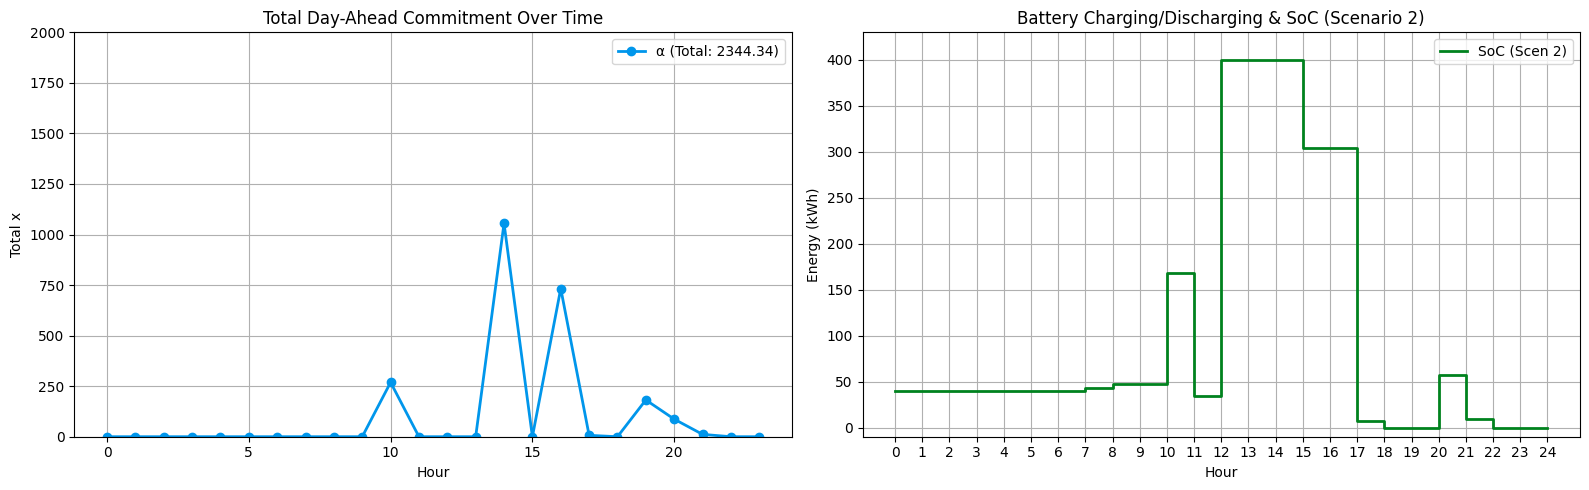

DA Profit      = 368519.31
RT Profit      = 799936.12
Penalty Cost   = 12779.16
Total Profit   = 1155676.27, Objective Val  = 1155676.27


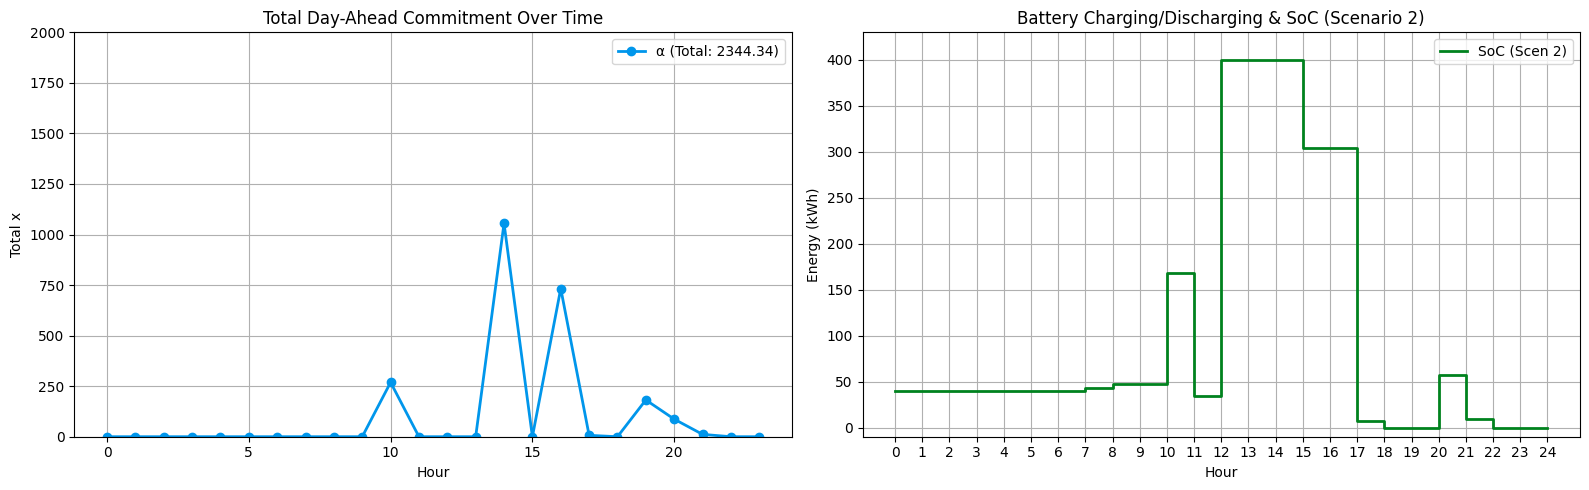

In [34]:
plot_summary(agg, K, P_DA, P_RT, P_PN, agg_a_vals, agg_bp_vals, agg_bm_vals, agg_g_vals, s=2)
plot_summary(set, K, P_DA, P_RT, P_PN, a_vals, bp_vals, bm_vals, g_vals, s=2)

In [36]:
for s, t, i in product(range(S), range(T), range(I)):
    print(f"[i={i} t={t:02}, s={s:02} BEFORE]  "
          f"R={R[i, t, s]:.2f}, x={x_vals[i, t, s]:.2f}, "
          f"y⁺={yp_vals[i, t, s]:.2f}, y⁻={ym_vals[i, t, s]:.2f}, "
          f"zᶜ={zc_vals[i, t, s]:.2f}, zᴰ={zd_vals[i, t, s]:.2f}, "
          f"z={z_vals[i, t, s]:.2f}")

    print(f"[i={i} t={t:02}, s={s:02} AFTER ]  "
          f"R={R[i, t, s]:.2f}, x={x_vals[i, t, s]:.2f}, "
          f"e⁺={ep_vals[i, t, s]:.2f}, e⁻={em_vals[i, t, s]:.2f}, "
          f"eᶜ={ec_vals[i, t, s]:.2f}, eᴰ={ed_vals[i, t, s]:.2f}, "
          f"z={z_vals[i, t, s]:.2f}")
    print()

[i=0 t=00, s=00 BEFORE]  R=0.00, x=0.00, y⁺=0.00, y⁻=0.00, zᶜ=0.00, zᴰ=0.00, z=10.00
[i=0 t=00, s=00 AFTER ]  R=0.00, x=0.00, e⁺=0.00, e⁻=0.00, eᶜ=0.00, eᴰ=0.00, z=10.00

[i=1 t=00, s=00 BEFORE]  R=0.00, x=0.00, y⁺=0.00, y⁻=0.00, zᶜ=0.00, zᴰ=0.00, z=10.00
[i=1 t=00, s=00 AFTER ]  R=0.00, x=0.00, e⁺=0.00, e⁻=0.00, eᶜ=0.00, eᴰ=0.00, z=10.00

[i=2 t=00, s=00 BEFORE]  R=0.00, x=0.00, y⁺=0.00, y⁻=0.00, zᶜ=0.00, zᴰ=0.00, z=10.00
[i=2 t=00, s=00 AFTER ]  R=0.00, x=0.00, e⁺=0.00, e⁻=0.00, eᶜ=0.00, eᴰ=0.00, z=10.00

[i=3 t=00, s=00 BEFORE]  R=0.00, x=0.00, y⁺=0.00, y⁻=0.00, zᶜ=0.00, zᴰ=0.00, z=10.00
[i=3 t=00, s=00 AFTER ]  R=0.00, x=0.00, e⁺=0.00, e⁻=0.00, eᶜ=0.00, eᴰ=0.00, z=10.00

[i=0 t=01, s=00 BEFORE]  R=0.00, x=0.00, y⁺=0.00, y⁻=0.00, zᶜ=0.00, zᴰ=0.00, z=10.00
[i=0 t=01, s=00 AFTER ]  R=0.00, x=0.00, e⁺=0.00, e⁻=0.00, eᶜ=0.00, eᴰ=0.00, z=10.00

[i=1 t=01, s=00 BEFORE]  R=0.00, x=0.00, y⁺=0.00, y⁻=0.00, zᶜ=0.00, zᴰ=0.00, z=10.00
[i=1 t=01, s=00 AFTER ]  R=0.00, x=0.00, e⁺=0.00, e⁻=0.00, e

In [37]:
rows = []
for t in range(6, 23):
    for s in range(S):
        for i in range(I):
            rows.append({
                "i": i,
                "t": t,
                "s": s,
                "공급가능": dyp_p[i, t, s].X + dyp_p[i, t, s].X + dzc_p[i, t, s].X + dzd_p[i, t, s].X,
                "수요": dyp_m[i, t, s].X + dym_m[i, t, s].X + dzc_m[i, t, s].X + dzd_m[i, t, s].X,
                "yp - ep": yp[i, t, s].X - ep[i, t, s].X,
                "dyp+": dyp_p[i, t, s].X,
                "dyp-": dyp_m[i, t, s].X,
                "ym - em": ym[i, t, s].X - em[i, t, s].X,
                "dym+": dyp_p[i, t, s].X,
                "dym-": dym_m[i, t, s].X,
                "zc - ec": zc[i, t, s].X - ec[i, t, s].X,
                "dzc+": dzc_p[i, t, s].X,
                "dzc-": dzc_m[i, t, s].X,
                "zd - ed": zd[i, t, s].X - ed[i, t, s].X,
                "dzd+": dzd_p[i, t, s].X,
                "dzd-": dzd_m[i, t, s].X,
            })

pd.DataFrame(rows)

,i,t,s,공급가능,수요,yp - ep,dyp+,dyp-,ym - em,dym+,dym-,zc - ec,dzc+,dzc-,zd - ed,dzd+,dzd-
0,0,6,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,1,6,0,0.640,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.640,0.640,0.000,0.000,0.000,0.000
2,2,6,0,3.257,0.000,1.629,1.629,0.000,0.000,1.629,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,3,6,0,0.000,2.268,0.000,0.000,0.000,0.000,0.000,0.000,-2.268,0.000,2.268,0.000,0.000,0.000
4,0,6,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5,1,6,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6,2,6,1,8.070,0.000,4.035,4.035,0.000,0.000,4.035,0.000,0.000,0.000,0.000,0.000,0.000,0.000
7,3,6,1,0.000,4.035,0.000,0.000,0.000,0.000,0.000,0.000,-4.035,0.000,4.035,0.000,0.000,0.000
8,0,6,2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
9,1,6,2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
